In [ ]:
%set_env LD_LIBRARY_PATH=~/miniconda3/envs/ppocr/lib:~/miniconda3/envs/ppocr/lib/python3.8/site-packages/tensorrt_bindings:/home/dtong/miniconda3/envs/ppocr/lib/python3.8/site-packages/tensorrt_libs

In [2]:
import mmcv
import pickle
# from wiring_inspect.main import InspectItem, wiring_match4, merge_ocr_thru_frames
from wiring_inspect.matcher import InspectItem, wiring_match, merge_ocr_thru_frames
import numpy as np
import time
import base64
import cv2
from collections import Counter
import pandas as pd
import typing as T

from wiring_inspect.main import init_ocr_model, init_segment_models, process_frame

/home/dtong/miniconda3/envs/ppocr/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# file_prefix = "1705318697798-junction_box"
file_prefix = "1705383802482-junction_box"
# file_prefix = "1705301175534-breaker"
# file_prefix = "1704777351462-junction_box"

with open(f"/mnt/P40_NFS/10_Projects/利德华福-北京/demo_project/process/result-rp/{file_prefix}.pkl", "rb") as f:
    data = pickle.load(f)
vid = mmcv.VideoReader(f"/mnt/P40_NFS/10_Projects/利德华福-北京/demo_project/process/video-rp/{file_prefix}.mp4")

pattern = {'/': {'body': [910, 1561, 1014, 1703], 'terminals': {'1': {'center': [962, 1561], 'radius': 60, 'min_dist': 50}, '2': {'center': [954, 2231], 'radius': 60, 'min_dist': 80}}}}
match_result = wiring_match(data, pattern, (2160, 3840), 360, ['junction_box'])

In [3]:
match_result['match_result']

[{'model_type': 'junction_box',
  'loc_marker': '*',
  'line_marker': {'7': {'line_track_id': 18,
    'device_track_id': 8,
    'text': '*'},
   '3': {'line_track_id': 26, 'device_track_id': 4, 'text': '*'},
   '2': {'line_track_id': 61, 'device_track_id': 13, 'text': '*'},
   '*': {'line_track_id': 69, 'device_track_id': 51, 'text': '*'}}},
 {'model_type': 'junction_box',
  'loc_marker': 'XT15',
  'line_marker': {'6': {'line_track_id': 204,
    'device_track_id': 208,
    'text': '-XT15:6'},
   '9': {'line_track_id': 246, 'device_track_id': 217, 'text': 'XT15:9'},
   '8': {'line_track_id': 220, 'device_track_id': 212, 'text': '-XT15:8'},
   '1': {'line_track_id': 175, 'device_track_id': 179, 'text': '-XT15:1'},
   '2': {'line_track_id': 180, 'device_track_id': 181, 'text': '-XT15:2'},
   '3': {'line_track_id': 182, 'device_track_id': 186, 'text': '-XT15:3'},
   '4': {'line_track_id': 192, 'device_track_id': 194, 'text': '-XT15:4'},
   '5': {'line_track_id': 213, 'device_track_id': 205

In [21]:
import json

class InspectItemJsonEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, InspectItem):
            box = obj.box_xyxy.numpy().astype(np.int64).tolist()
            mask = obj.mask_xy.astype(np.int64).tolist()
            return {
                "frame_idx": obj.frame_idx,
                "box": box,
                "mask": mask,
            }
        return json.JSONEncoder.default(self, obj)
with open("output.json", "w") as f:
    filtered_device_tracks = {}
    filtered_lm_tracks = {}
    for device_match in match_result['match_result']:
        for lm_match in device_match['line_marker'].values():
            filtered_device_tracks[int(lm_match['device_track_id'])] = match_result['track_result']['junction_box'][lm_match['device_track_id']]
            filtered_lm_tracks[int(lm_match['line_track_id'])] = match_result['track_result']['line_marker'][lm_match['line_track_id']]
    f.write(json.dumps({"device": filtered_device_tracks, "line_marker": filtered_lm_tracks}, cls=InspectItemJsonEncoder))
    # f.write(json.dumps(filtered_device_tracks, cls=InspectItemJsonEncoder))
# result = json.dumps(match_result['track_result']['line_marker'], cls=InspectItemJsonEncoder)

In [10]:
match_result['dist_matrix'].loc[[("junction_box", 208, "1")], [204]]

,,,204
device_type,device_id,terminal_key,
junction_box,208,1,2.848968


In [ ]:
match_result['dist_matrix'].loc[
    [
        ("junction_box", 157, 1), 
        ("junction_box", 164, 1), 
        ("junction_box", 171, 1), 
        ("junction_box", 176, 1), 
        ("junction_box", 183, 1),
        ("junction_box", 187, 1),
        ("junction_box", 193, 1),
        ("junction_box", 195, 1),
        ("junction_box", 200, 1),
        ("junction_box", 204, 1),
        ("junction_box", 206, 1),
    ], 
    [152,158,159,165,169,172,178,179,181,184,185,188,190,194]]

## 查看分割检测跟踪结果

In [ ]:
len(match_result['track_result']['line_marker'][19])

In [7]:
[(k, match_result['ocr_result'][v[0].target_type][v[0].track_id], Counter([t.text_words[0] for t in v if t.text_words]).most_common(3)) for k, v in match_result['track_result']['line_marker'].items()]

[(1, '-XT15:16', [('-XT15:16', 9), ('LIE', 1)]),
 (2, '*', [('-XT15:6', 3), ('XT15:6', 3), ('XT15:8', 1)]),
 (3, '-XT15:13', [('-XT15:13', 9), ('-XI155', 1), ('X115:5', 1)]),
 (4, '-XT15:14', [('-XT15:14', 7), ('-XT15:15', 1), ('X11919', 1)]),
 (5, '-XT15:9', [('-XT15:9', 7), ('XT15:9', 2), ('-XT153', 1)]),
 (6, '-XT15:1', [('-XT15:1', 6), ('-XT151', 1), ('XT15:1', 1)]),
 (7, '-XT15:4', [('-XT15:4', 8), ('XT15:4', 1), ('X1154', 1)]),
 (8, '-XT15:12', [('-XT15:12', 5), ('XT15:12', 2), ('-XT15-12', 2)]),
 (9, '-XT15:15', [('-XT15:15', 8), ('XT15:15', 1), ('XT15-', 1)]),
 (10, '*', []),
 (11, 'XT15:11', [('XT15:11', 6), ('-XT15:11', 2), ('XT15-4', 2)]),
 (12, '-XT15:10', [('-XT15:10', 4), ('-XI155', 1), ('-XT15:5', 1)]),
 (13, 'XT15:7', [('XT15:7', 8), ('-XT15:7', 1), ('A7R', 1)]),
 (14, '-XT15:2', [('-XT15:2', 8), ('XT15:2', 1), ('X116-1', 1)]),
 (15, '*', [('-XT15:9', 2), ('XT15:9', 2), ('HNM', 1)]),
 (16, '*', [('-XT15:2', 1), ('XT152', 1), ('-AT152', 1)]),
 (17, '-XT15:6', [('-XT15:6'

In [ ]:
match_result['track_result']['line_marker'][208][0].frame_idx

In [ ]:
[(k, match_result['ocr_result'][v[0].target_type][v[0].track_id], Counter([t.text_words[0] for t in v if t.text_words]).most_common(3)) for k, v in match_result['track_result']['junction_box'].items()]

In [15]:
left = (2160 - 360) // 2
right = (2160 + 360) // 2

def draw_track(vid, match_result, targets: T.List[T.Tuple[str, int]]):
    target_tracks = [match_result['track_result'][t[0]][t[1]] for t in targets]
    frame_idxs = set()
    for track in target_tracks:
        frame_idxs.update([i.frame_idx for i in track])
    frame_idxs = sorted(list(frame_idxs))
    
    result = []
    for frame_idx in frame_idxs:
        frame = vid[frame_idx]
        cv2.line(frame, (left, 0), (left, 3840), (0, 0, 255), 5)
        cv2.line(frame, (right, 0), (right, 3840), (0, 0, 255), 5)
        for ti, (target_type, target_id) in enumerate(targets):
            track = match_result['track_result'][target_type][target_id]
            track_frame_idxs = [i.frame_idx for i in track]
            if frame_idx in track_frame_idxs:
                item = track[track_frame_idxs.index(frame_idx)]
                cv2.polylines(frame, [item.mask_xy.astype(np.int32)], True, (0, 255 // (ti+1), 0), 5)
                # if (item.target_type == "line_marker"):
                #     cv2.arrowedLine(frame, (1920, 1080), item.bottom_point.astype(np.int32), (0, 255 // (ti+1), 0), 5)
            if (target_type, frame_idx, target_id) in match_result['pattern_debug_info']:
                pattern = match_result['pattern_debug_info'][(target_type, frame_idx, target_id)]
                x1, y1, x2, y2 = pattern['body']
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 5)
                for tmnl in pattern['terminals'].values():
                    xc, yc = tmnl['center']
                    cv2.circle(frame, (int(xc), int(yc)), int(tmnl['radius']), (0, 0, 255), -1)
        result.append(frame)
    return result


In [16]:
frames = draw_track(vid, match_result, [("junction_box", 208), ("line_marker", 204)])

In [ ]:
frames = draw_track(vid, match_result, [
    ("junction_box", 157), 
    ("junction_box", 164), 
    ("junction_box", 171), 
    ("line_marker", 142), 
    ("line_marker", 145)
    ])

In [ ]:
frames = draw_track(vid, match_result, [
    ("line_marker", 208), 
    # ("line_marker", 210), 
    # ("line_marker", 215), 
    ("line_marker", 244)
    ])

In [ ]:
frames = draw_track(vid, match_result, [
    ("line_marker", 224), 
    ("line_marker", 225), 
    ("line_marker", 231)
    ])

In [ ]:
frames = draw_track(vid, match_result, [
    ("line_marker", 266), 
    ("line_marker", 268), 
    ("line_marker", 269),
    ("line_marker", 272)
    ])

In [ ]:
frames = draw_track(vid, match_result, [
    ("line_marker", 152), 
    ("line_marker", 159), 
    ])

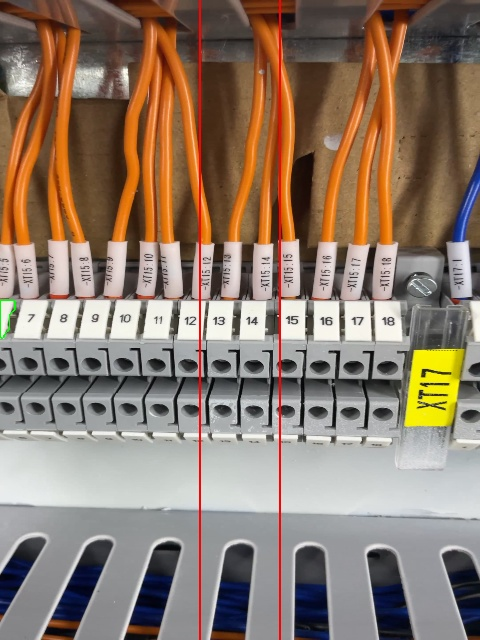

In [17]:
# 在notebook中连续显示图片
display_handle = display(None, display_id=True)
from IPython.display import display, Image
for f in frames[:]:
    f = cv2.resize(f, (480, 640))
    display_handle.update(Image(data=cv2.imencode('.jpg', f)[1]))
    time.sleep(0.2)

In [20]:
out = cv2.VideoWriter("clip.mp4", cv2.VideoWriter.fourcc(*'mp4v'), 30, (2160, 3840))
for frame in frames:
    out.write(frame)
out.release()

In [ ]:
for idx, frame in enumerate(frames[30:60]):
    cv2.imwrite(f"frame_{idx}.jpg", frame)

In [ ]:
writer = cv2.VideoWriter(f"track-line_marker-29.mp4", cv2.VideoWriter_fourcc(*"mp4v"), 30, (480, 640))
for frame in frames:
    frame = cv2.resize(frame, (480, 640))
    writer.write(frame)
writer.release()

In [ ]:
vid.get_frame(0).shape

In [ ]:
final_result, device_tracking_map, dist_matrix, row_ind, col_ind, dist_row_inds, dist_col_inds = wiring_match3(data, (2160, 3840))

In [ ]:
dist_matrix[:, 1]

In [ ]:
img = cv2.resize(vid.get_frame(250), (480, 640))
# 图片水平翻转
img = cv2.flip(img, 1)
line_det = cv2.createLineSegmentDetector(0)
lines = line_det.detect(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

vis_img = img.copy()
for i, line in enumerate(lines[0]):
    x1, y1, x2, y2 = line[0]
    line_length = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    line_angle = np.arctan2(y2 - y1, x2 - x1) / np.pi / 2
    if line_length > 200:
        print(i, line_length, line_angle)
        cv2.line(vis_img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 5)
        cv2.putText(vis_img, str(i), (int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
Image.fromarray(vis_img)

In [ ]:
%env


In [ ]:
from PIL import Image
Image.fromarray(cv2.resize(vid.get_frame(250), (480, 640)))

In [ ]:
seg_model_dict = init_segment_models(["line_marker", "junction_box", "loc_marker"])
ocr_model = init_ocr_model()

frame_result, visual_frame = process_frame(250, vid.get_frame(250), seg_model_dict, ocr_model)